# 측정 오류 완화

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute

### 소개

잡음의 영향으로 인해 출력이 정확하지 않습니다. 각 게이트가 각 오류의 영향을 어떻게 변환하는지 고려해야 하므로 계산 전체에서 발생하는 잡음의 영향은 일반적으로 매우 복잡합니다.

더 단순한 형태의 잡음은 마지막 측정 중에 발생하는 노이즈입니다. 이 시점에서 회로에 남아 있는 유일한 작업은 비트열을 출력으로 얻는 것입니다. $n$ 큐비트 마지막 측정의 경우 이는 $2^n$ 가능한 $n$ 비트열 중 하나를 얻는 것을 의미합니다. 이 과정에서 간단한 잡음의 모델로, 완벽히 잡음이 없는 상태에서 측정을 구한 다음 잡음으로 인해 이 출력이 무작위로 교란된다고 생각할 수 있습니다.

이 잡음 모델에 대해 측정 오류의 영향이 무엇인지 정확히 결정하는 것은 매우 쉽습니다. $2^n$ 개의 가능한 기저 상태를 각각 준비한 다음 즉시 측정하고 각 결과에 대한 확률을 확인할 수 있습니다.

예를 들어 우선 확률 $p$로 출력의 각 비트를 무작위로 뒤집는 간단한 잡음 모델을 생성합니다.

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):
    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

측정 횟수의 $1%$ 만큼 각 비트를 뒤집히는 예부터 시작하겠습니다.

In [3]:
noise_model = get_noise(0.01)

이제 그 효과를 실험할 수 있습니다. 구체적으로 2 큐비트 회로를 정의하고 $\left|00\right\rangle$, $\left|01\right\rangle$, $\left|10\right\rangle$, $\left|11\right\rangle$ 상태를 준비합니다. 잡음이 없으면 이들은 각각 명확한 출력 `'00'` , `'01'` , `'10'`, `'11'` 이 됩니다. 잡음에 어떤 일이 일어나는지 봅시다. 여기와 이 글의 나머지 부분에서 각 회로를 `shots=10000`번 실행하여 표본을 얻습니다.

In [4]:
for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    if state[0]=='1':
        qc.x(1)
    if state[1]=='1':
        qc.x(0)  
    qc.measure(qc.qregs[0],qc.cregs[0])
    print(state +' becomes',
          execute(qc, Aer.get_backend('qasm_simulator'),
                  noise_model=noise_model,shots=10000).result().get_counts())

00 becomes {'01': 108, '11': 1, '10': 110, '00': 9781}
01 becomes {'10': 1, '11': 106, '00': 88, '01': 9805}
10 becomes {'01': 2, '00': 90, '11': 86, '10': 9822}
11 becomes {'01': 91, '10': 84, '11': 9825}


여기서 올바른 출력이 확실히 가장 우세하다는 것을 알 수 있습니다. 단일 비트만 다른 것(예: 올바른 출력이 `'00'` 또는 `'11'` 인 경우 `'01'` , `'10'`)은 약 $1%$ 번 발생합니다. 2비트 차이가 나는 경우는 10000개 표본에서 몇 번만 발생합니다.

그렇다면 동일한 잡음 모델로 회로를 실행하고 다음과 같은 결과를 얻는다면 어떨까요?

`{'10': 98, '11': 4884, '01': 111, '00': 4907}`

여기서 `'01'` 과 `'10'` 은 모든 표본의 약 $1%$ 만큼 발생합니다. 초기 상태에 대한 분석을 통해 이러한 결과가 실제로는 발생하지 않아야 할 때 그러한 결과가 예상될 수 있다는 것을 알고 있지만 대신 결과는 `'00'` 또는 `'11'` 과 같이 그들과 단 한 비트만 다른 무언가여야 합니다. 이 두 결과에 대한 결과를 보면 거의 동일한 확률로 발생한다는 것을 알 수 있습니다. 따라서 우리는 초기 상태가 단순히 $\left|00\right\rangle$ 또는 $\left|11\right\rangle$이 아니라 둘의 동일한 중첩이라는 결론을 내릴 수 있습니다. true인 경우 결과가 다음과 같아야 함을 의미합니다.

`{'11': 4977, '00': 5023}`

다음은 이와 같은 결과를 생성하는 회로입니다(통계적 변동까지).

In [5]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure(qc.qregs[0],qc.cregs[0])
print(execute(qc, Aer.get_backend('qasm_simulator'),
              noise_model=noise_model,shots=10000).result().get_counts())

{'01': 83, '10': 102, '11': 5006, '00': 4809}


이 예에서 우리는 먼저 각 한정된 기저 상태에 대한 결과를 살펴보고 이러한 결과를 사용하여 보다 일반적인 형태의 상태에 대한 오류의 영향을 완화했습니다. 이것이 측정 오류 완화의 기본 원리입니다.

### 선형 대수를 사용한 오류 완화

이제 수동이 아닌 알고리즘으로 오류를 완화하는 방법을 찾아야 합니다. 행렬을 이용한 무작위 프로세스를 활용해서 이를 수행할 것입니다. 이를 위해 카운트 딕셔너리를 열 벡터로 다시 작성해야 합니다. 예를 들어 딕셔너리 `{'10': 96, '11': 1, '01': 95, '00': 9808}`은 다음과 같이 쓸 수 있습니다.

$$ C = \begin{pmatrix} 9808 \ 95 \ 96 \ 1 \end{pmatrix}. $$

여기서 첫 번째 요소는 `'00'` 에 대한 것이고 다음 요소는 `'01'` 에 대한 것 입니다.

기본 상태 $\left|00\right\rangle$, $\left|01\right\rangle$, $\left|10\right\rangle$, $\left|11\right\rangle$에서 수집한 정보로 이상적인 카운트 집합에서 측정 잡음의 영향을 받은 집합으로 만드는 행렬을 정의할 수 있습니다. 이것은 단순히 $\left|00\right\rangle$에 대한 카운트 딕셔너리를 가져와 모든 요소의 합이 1이 되도록 정규화한 다음 이를 행렬의 첫 번째 열로 사용하여 수행됩니다. 다음 열은 $\left|01\right\rangle$에 대해 얻은 카운트 딕셔너리로 유사하게 정의합니다.

각 기저 상태에 대해 회로를 실행할 때 마다 통계적 변화가 있습니다. 다음에서는 이 글을 작성할 때 구한 다음과 같은 데이터를 사용합니다.

```code
00 becomes {'10': 96, '11': 1, '01': 95, '00': 9808}
01 becomes {'10': 2, '11': 103, '01': 9788, '00': 107}
10 becomes {'10': 9814, '11': 90, '01': 1, '00': 95}
11 becomes {'10': 87, '11': 9805, '01': 107, '00': 1}
```

이것으로 다음 행렬을 만들 수 있습니다.

$$ M = \begin{pmatrix} 0.9808&amp;0.0107&amp;0.0095&amp;0.0001 \ 0.0095&amp;0.9788&amp;0.0001&amp;0.0107 \ 0.0096&amp;0.0002&amp;0.9814&amp;0.0087 \ 0.0001&amp;0.0103&amp;0.0090&amp;0.9805 \end{pmatrix} $$

이제 이상적인 결과 벡터에 이 매트릭스를 적용하면 측정 잡음이 있는 근사적인 결과를 얻을 수 있습니다.

$$ C_\text{noisy} = M ~ C_\text{ideal}$$

예를 들어 $(\left|00\right\rangle+\left|11\right\rangle)/\sqrt{2}$ 상태에 대해 이 과정을 적용해 보겠습니다.

# $$ \begin{pmatrix} 0.9808&amp;0.0107&amp;0.0095&amp;0.0001 \ 0.0095&amp;0.9788&amp;0.0001&amp;0.0107 \ 0.0096&amp;0.0002&amp;0.9814&amp;0.0087 \ 0.0001&amp;0.0103&amp;0.0090&amp;0.9805 \end{pmatrix} \begin{pmatrix} 5000 \ 0 \ 0 \ 5000 \end{pmatrix}

이를 코드로 표현하면 다음과 같습니다.

In [6]:
import numpy as np

M = [[0.9808,0.0107,0.0095,0.0001],
    [0.0095,0.9788,0.0001,0.0107],
    [0.0096,0.0002,0.9814,0.0087],
    [0.0001,0.0103,0.0090,0.9805]]

Cideal = [[5000],
          [0],
          [0],
          [5000]]

Cnoisy = np.dot(M, Cideal)
print('C_noisy =\n', Cnoisy)

C_noisy =
 [[4904.5]
 [ 101. ]
 [  91.5]
 [4903. ]]


어느 쪽이든, 측정 잡음이 있는 경우  $(\left|00\right\rangle+\left|11\right\rangle)/\sqrt{2}$를 측정한 결과 카운트 $C_\text{noisy}$는 이전에 구한 실제 데이터와 매우 근접합니다. 따라서 이 매트릭스 방법은 실제로 결과에 대한 정보가 있는 경우 잡음이 있는 결과를 예측하는 좋은 방법입니다.

불행히도 이것은 필요로 하는 것과 정반대입니다. 이상적인 카운트 데이터를 잡음 데이터로 변환하는 방법 대신 잡음 데이터를 이상적인 데이터로 변환하는 방법이 필요합니다. 선형 대수학에서는 역행렬 $M^{-1}$를 찾아 행렬 $M$에 대해 이 작업을 수행합니다.

$$C_\text{ideal} = M^{-1} C_\text{noisy}.$$


In [7]:
import scipy.linalg as la

M = [[0.9808,0.0107,0.0095,0.0001],
    [0.0095,0.9788,0.0001,0.0107],
    [0.0096,0.0002,0.9814,0.0087],
    [0.0001,0.0103,0.0090,0.9805]]

Minv = la.inv(M)

print(Minv)

[[ 1.01978044e+00 -1.11470783e-02 -9.87135367e-03  1.05228426e-04]
 [-9.89772783e-03  1.02188470e+00  9.39504466e-05 -1.11514471e-02]
 [-9.97422955e-03 -4.05845410e-06  1.01913199e+00 -9.04172099e-03]
 [ 9.15212840e-05 -1.07335657e-02 -9.35458279e-03  1.02008794e+00]]


이 역을 $C_\text{noisy}$에 적용하면 실제 카운트의 근사치를 얻을 수 있습니다.

In [8]:
Cmitigated = np.dot(Minv, Cnoisy)
print('C_mitigated =\n', Cmitigated)

C_mitigated =
 [[5.00000000e+03]
 [0.00000000e+00]
 [1.42108547e-14]
 [5.00000000e+03]]


물론 개수는 정수여야 하므로 이 값을 반올림해야 합니다. 결과는 매우 좋습니다. $$ C_\text{mitigated} = \begin{pmatrix} 5000 \ 0 \ 0 \ 5000 \end{pmatrix} $$

이것은 올바른 결과입니다. 오류 완화가 잘 되었습니다!

### Qiskit의 오류 완화

In [9]:
from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter

측정 오류 완화 프로세스는 Qiskit의 도구를 사용하여 수행할 수도 있습니다. 이는 기본 상태에 대한 데이터 수집, 행렬 구성, 역 계산을 처리합니다. 역 계산은 위에서 본 것처럼 의사 역을 사용하여 수행할 수 있습니다. 그러나 최소 제곱 피팅을 사용하는 훨씬 더 정교한 방법이 기본으로 되어있습니다.

예를 들어 큐비트 쌍에 대한 오류 완화를 계속 수행해 보겠습니다. 이를 위해 우리는 2큐비트 양자 레지스터를 정의하고 이를 `complete_meas_cal` 함수에 입력합니다.

In [10]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

이것은 두 큐비트 네 가지 기본 상태 $\left|00\right\rangle$, $\left|01\right\rangle$, $\left|10\right\rangle$, $\left|11\right\rangle$ 각각을 측정하는 회로 집합을 생성합니다.

In [11]:
for circuit in meas_calibs:
    print('Circuit', circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
        ░ ┌─┐   
q20_0: ─░─┤M├───
        ░ └╥┘┌─┐
q20_1: ─░──╫─┤M├
        ░  ║ └╥┘
 c0: 2/════╩══╩═
           0  1 

Circuit mcalcal_01
       ┌───┐ ░ ┌─┐   
q20_0: ┤ X ├─░─┤M├───
       └───┘ ░ └╥┘┌─┐
q20_1: ──────░──╫─┤M├
             ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_10
             ░ ┌─┐   
q20_0: ──────░─┤M├───
       ┌───┐ ░ └╥┘┌─┐
q20_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_11
       ┌───┐ ░ ┌─┐   
q20_0: ┤ X ├─░─┤M├───
       ├───┤ ░ └╥┘┌─┐
q20_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 



이제 잡음 없이 이 회로를 실행해 보겠습니다.

In [12]:
# Execute the calibration circuits without noise
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

그 결과로 보정 행렬 $M$을 구성할 수 있습니다.

In [13]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


잡음이 없으면 이것은 단순히 항등 행렬입니다.

이제 잡음 모델을 만들어 보겠습니다. 그리고 이전보다 더 흥미롭게 오류가 10배 더 발생하도록 만듭니다.

In [14]:
noise_model = get_noise(0.1)

다시 회로를 실행하고 보정 행렬 $M$를 볼 수 있습니다.

In [15]:
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.8   0.086 0.095 0.008]
 [0.091 0.817 0.01  0.087]
 [0.099 0.014 0.805 0.095]
 [0.01  0.083 0.09  0.81 ]]


이번에는 좀 더 흥미로운 행렬을 찾았고 이전에 설명한 접근 방식에서는 사용할 수 없는 행렬을 찾았습니다. 이 잡음을 얼마나 잘 완화할 수 있는지 봅시다. 다시 한 번 실험에 벨 상태 $(\left|00\right\rangle+\left|11\right\rangle)/\sqrt{2}$를 사용하겠습니다.

In [16]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure(qc.qregs[0],qc.cregs[0])

results = execute(qc, backend=backend, shots=10000, noise_model=noise_model).result()

noisy_counts = results.get_counts()
print(noisy_counts)

{'01': 910, '10': 889, '11': 4048, '00': 4153}


Qiskit에서는 측정 필터 객체를 생성하여 잡음을 완화합니다. 그런 다음 위의 결과를 사용하여 완화된 카운트 집합을 계산합니다. Qiskit은 이것을 딕셔너리로 반환하므로 사용자는 결과를 얻기 위해 벡터 자체를 사용할 필요가 없습니다.

In [17]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

결과를 가장 명확하게 보기 위해 잡음이 있는 결과와 완화된 결과를 모두 그려 보겠습니다.

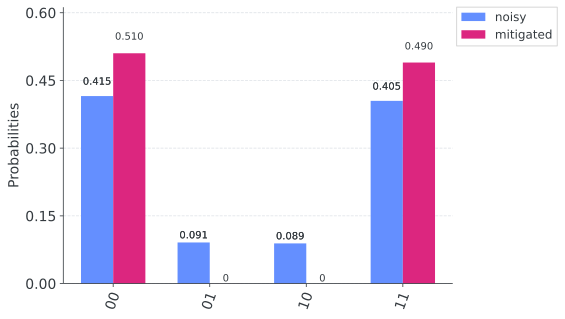

In [18]:
from qiskit.visualization import plot_histogram 
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

여기서 표본의 거의 $20%$가 잘못된 결과와 이를 올바르게 바꾼 참 결과를 표현했습니다. 그러나 이 예에는 간단한 잡음 모델이 있는 큐비트가 두 개뿐입니다. 더 많은 큐비트와 더 복잡한 잡음 모델 또는 실제 장치의 데이터의 경우 완화에 더 많은 어려움이 있습니다. Qiskit이 사용하는 방법보다 더 나은 방법을 찾을 수도 있습니다!

In [19]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.21.2', 'qiskit-aer': '0.10.4', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.37.2', 'qiskit-nature': '0.4.1', 'qiskit-finance': '0.3.2', 'qiskit-optimization': '0.4.0', 'qiskit-machine-learning': '0.4.0'}